In [231]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [232]:
pip install -U -q --use-deprecated=legacy-resolver tf-models-official tensorflow

In [233]:
### https://saturncloud.io/blog/how-to-change-the-path-in-google-colab/

from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/dataset')

pwd = '/content/drive/My Drive/Colab Notebooks/dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [271]:
def data_processing(data , half_chapter ):
    filepath = os.path.join(pwd, data)
    df = pd.read_csv(filepath,  index_col=0)
    df = df.dropna(axis=1, how='all')
    df = df[ df['nchapters'] >= half_chapter ]
    # Delete unrelated columns
    df = df.drop(columns= ['course_id','userid_DI','registered','viewed','explored',
                           'start_time_DI','last_event_DI','incomplete_flag','final_cc_cname_DI'] , axis = 1)
    df = df.dropna( how='any', axis=0)
    df = df[ df['grade']!= " " ]
    df['grade'] = pd.to_numeric(df['grade'])

    if data == "HarvardX_CB22x_2013_Spring.csv" or data == "HarvardX_ER22x_2013_Spring.csv":
      df.loc[:,'nplay_video'] = 0

    y = df.pop('certified')
    #print( y.value_counts() )
    X = pd.get_dummies(df, dtype=float)
    y = y.to_numpy()
    # y = y.reshape(-1,1)
    X = X.to_numpy()
    return X, y

# np.any --> Test whether any array element along a given axis evaluates to True.
# res =  np.any( np.isnan(X), axis = 0)

In [272]:
seed = 34

In [273]:
# None Shift
X, y =  data_processing(data = 'MITx_6.00x_2012_Fall.csv', half_chapter = 9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= seed)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2044, 14)
(228, 14)
(569, 14)


In [274]:
# Samll Shift
X_small_shift, y_small_shift =  data_processing(data = 'MITx_6.00x_2013_Spring.csv', half_chapter = 9)
scaler = StandardScaler()
X_small_shift = scaler.fit_transform(X_small_shift)
X_small_shift.shape

(2330, 14)

In [275]:
# Large Shift
X_large_shift, y_large_shift =  data_processing(data ='HarvardX_CB22x_2013_Spring.csv', half_chapter = 14)
scaler = StandardScaler()
X_large_shift = scaler.fit_transform(X_large_shift)
X_large_shift.shape

(434, 14)

In [276]:
# Large Shift 2
X_large_shift_2, y_large_shift_2 =  data_processing(data ='HarvardX_ER22x_2013_Spring.csv', half_chapter = 17 )
scaler = StandardScaler()
X_large_shift_2 = scaler.fit_transform(X_large_shift_2)
X_large_shift_2.shape

(2868, 14)

In [305]:
# OOD data 1
X_OOD_1 = pd.read_csv('sonar_X.csv')
y_OOD_1 = pd.read_csv('sonar_y.csv')
X_OOD_1 = X_OOD_1.to_numpy()
y_OOD_1 = y_OOD_1.to_numpy()
X_OOD_1.shape

(207, 14)

In [306]:
# OOD data 2
X_OOD_2 = pd.read_csv('ionosphere_X.csv')
y_OOD_2 = pd.read_csv('ionosphere_y.csv')
X_OOD_2 = X_OOD_2.to_numpy()
y_OOD_2 = y_OOD_2.to_numpy()
X_OOD_2.shape

(351, 14)

In [244]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets
import numpy as np
import tensorflow as tf
import official.nlp.modeling.layers as nlp_layers

tf.random.set_seed(12)
tf.keras.utils.set_random_seed(12)
tf.config.experimental.enable_op_determinism()

In [254]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the ResNet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [255]:
resnet_config = dict(num_classes = 2, num_layers= 2, num_hidden= 64)
resnet_model = DeepResNet(**resnet_config)
resnet_model.build( (None, 14) )
resnet_model.summary()

Model: "deep_res_net_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            multiple                  960       
                                                                 
 dense_76 (Dense)            multiple                  4160      
                                                                 
 dense_77 (Dense)            multiple                  4160      
                                                                 
 dense_78 (Dense)            multiple                  130       
                                                                 
Total params: 9410 (36.76 KB)
Trainable params: 8450 (33.01 KB)
Non-trainable params: 960 (3.75 KB)
_________________________________________________________________


In [256]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-4)

train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict(batch_size = 32, epochs= 1000,
               validation_data = (X_val, y_val),
               callbacks=[callback] )

In [ ]:
resnet_model.compile(**train_config)
history = resnet_model.fit( X_train, y_train, **fit_config)

<Axes: >

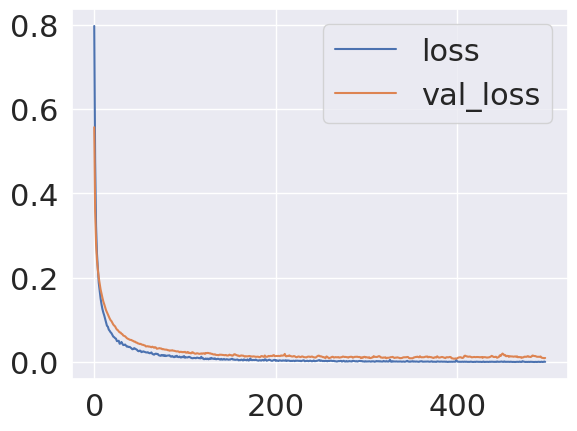

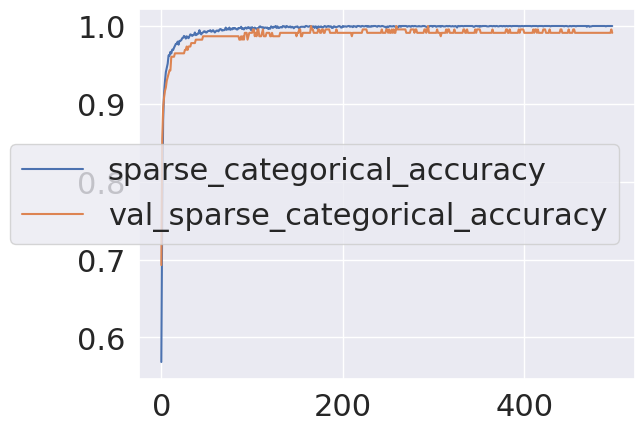

In [259]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()
# print(("Best Validation Loss: {:0.4f}" +\
#       "\nBest Validation Accuracy: {:0.4f}")\
#       .format(history_df['val_loss'].min(),
#               history_df['val_sparse_categorical_accuracy'].max()))

In [260]:
resnet_logits = resnet_model(X_test)
resnet_probs = tf.nn.softmax(resnet_logits, axis=-1)[:, 0]  # Take the probability for class 0.

In [261]:
from sklearn.metrics import accuracy_score
probs = np.where( resnet_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_test, probs)
accuracy

0.9912126537785588

In [262]:
resnet_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 0.0213 - sparse_categorical_accuracy: 0.9912


[0.021342210471630096, 0.9912126660346985]

In [263]:
resnet_model.evaluate(X_small_shift, y_small_shift)

73/73 [==============================] - 0s 1ms/step - loss: 0.5498 - sparse_categorical_accuracy: 0.9313


[0.5497515797615051, 0.9313304424285889]

In [279]:
resnet_model.evaluate(X_large_shift, y_large_shift)

14/14 [==============================] - 0s 2ms/step - loss: 0.9363 - sparse_categorical_accuracy: 0.8963


[0.9362534880638123, 0.8963133692741394]

In [280]:
resnet_model.evaluate(X_large_shift_2, y_large_shift_2)

90/90 [==============================] - 0s 1ms/step - loss: 0.2103 - sparse_categorical_accuracy: 0.9651


[0.21027405560016632, 0.965132474899292]

In [281]:
resnet_model.evaluate(X_OOD_1, y_OOD_1)

7/7 [==============================] - 0s 2ms/step - loss: 8.2798 - sparse_categorical_accuracy: 0.6425


[8.279844284057617, 0.6425120830535889]

In [282]:
resnet_model.evaluate(X_OOD_2, y_OOD_2)

11/11 [==============================] - 0s 2ms/step - loss: 18.8000 - sparse_categorical_accuracy: 0.4615


[18.80000877380371, 0.4615384638309479]

In [286]:
class DeepResNetSNGP(DeepResNet):
  #
  def __init__( self, spec_norm_bound = 0.9, **kwargs ):
    self.spec_norm_bound = spec_norm_bound

    super().__init__(**kwargs)

  # Override the father class's method
  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier = self.spec_norm_bound)

  # Override the father class's method
  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes,
        gp_cov_momentum = -1,
        **self.classifier_kwargs)
  #
  def call(self, inputs, training=False, return_covmat=False):

    # Gets logits and a covariance matrix from the GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [ ]:
# Implement a Keras callback to reset the covariance matrix at the beginning of a new epoch.

In [287]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [288]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())
    return super().fit(*args, **kwargs)

In [ ]:
# No earlystopping in SNGP

In [290]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 100,
                                            restore_best_weights = True)

fit_config = dict(batch_size = 32, epochs = 1000,
               validation_data = (X_val, y_val),
                callbacks=[callback]
               )

In [291]:
resnet_config = dict(num_classes = 2, num_layers= 2, num_hidden = 64)
sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

sngp_model.compile(**train_config)
history = sngp_model.fit(X_train, y_train, **fit_config)

Epoch 1/1000
64/64 [==============================] - 1s 8ms/step - loss: 0.6644 - sparse_categorical_accuracy: 0.6739 - val_loss: 0.6341 - val_sparse_categorical_accuracy: 0.8070
Epoch 2/1000
64/64 [==============================] - 0s 5ms/step - loss: 0.6207 - sparse_categorical_accuracy: 0.8444 - val_loss: 0.5972 - val_sparse_categorical_accuracy: 0.8377
Epoch 3/1000
64/64 [==============================] - 0s 4ms/step - loss: 0.5882 - sparse_categorical_accuracy: 0.8836 - val_loss: 0.5659 - val_sparse_categorical_accuracy: 0.8596
Epoch 4/1000
64/64 [==============================] - 0s 6ms/step - loss: 0.5607 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.5373 - val_sparse_categorical_accuracy: 0.8904
Epoch 5/1000
64/64 [==============================] - 0s 7ms/step - loss: 0.5362 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.5130 - val_sparse_categorical_accuracy: 0.9035
Epoch 6/1000
64/64 [==============================] - 0s 7ms/step - loss: 0.5127 - sparse_categorica

<Axes: >

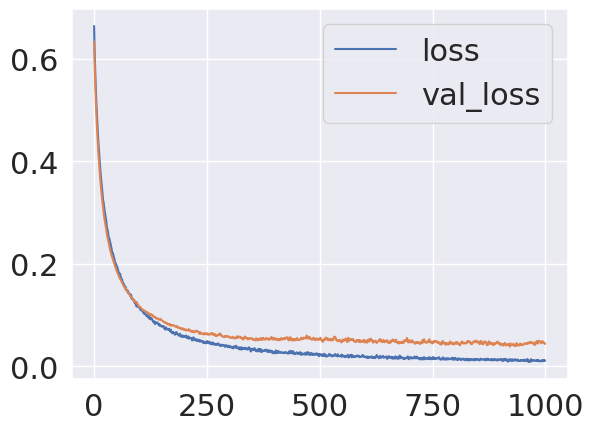

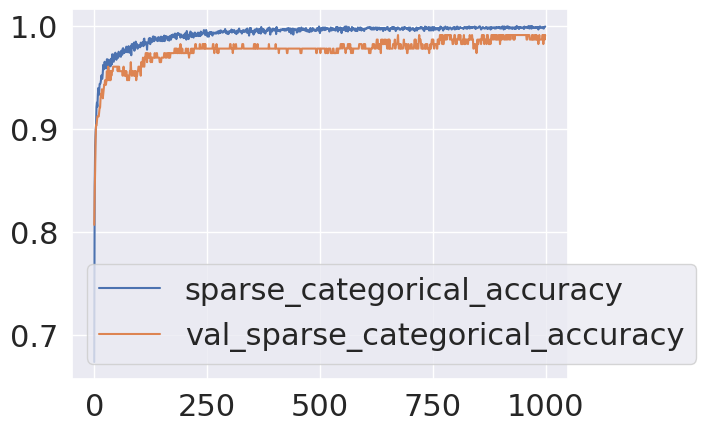

In [292]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot()
history_df.loc[:, ['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot()

In [ ]:
# # First compute the predictive logits and variances.
# sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
# sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]

In [ ]:
# # Now compute the posterior predictive probability
# sngp_logits_adjusted = sngp_logits / tf.sqrt(1. + (np.pi / 8.) * sngp_variance)
# sngp_probs = tf.nn.softmax(sngp_logits_adjusted, axis=-1)[:, 0]


In [293]:
# This mean-field method is implemented as a built-in function layers.gaussian_process.mean_field_logits:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)[:,0]



In [298]:
from sklearn.metrics import accuracy_score
sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_test, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.47838295
0.9876977152899824
0.011272325


In [299]:
sngp_logits, sngp_covmat = sngp_model(X_small_shift, return_covmat=True)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_small_shift, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.5078415
0.924892703862661
0.01987555


In [300]:
sngp_logits, sngp_covmat = sngp_model(X_large_shift, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.69542414
0.7741935483870968
0.12162126


In [301]:
sngp_logits, sngp_covmat = sngp_model(X_large_shift_2, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift_2, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.67219836
0.9034170153417015
0.07071241


0.017549526


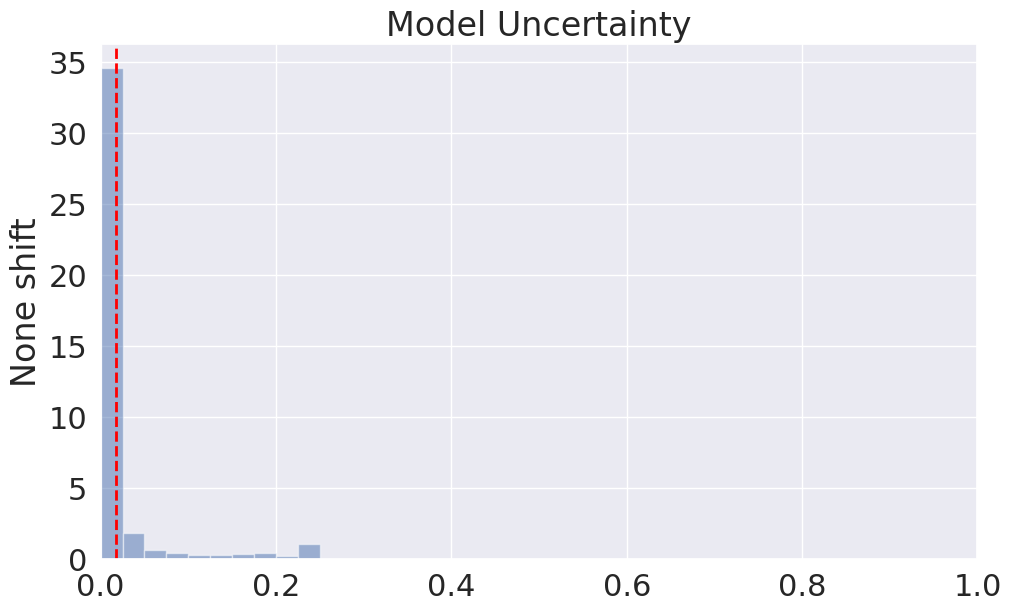

In [ ]:
# import seaborn as sns
# sns.set(font_scale=2)

# def plot_uncertainty(uncertainty, mean_val, ylabel = 'None shift'):
#   fig, ax = plt.subplots(figsize=(10, 6), layout='constrained')
#   # the histogram of the data
#   n, bins, patches = ax.hist(uncertainty, 10, density=True, facecolor='C0', alpha=0.5)
#   ax.axvline(mean_val, c = 'red', ls='--', lw=2,)
#   plt.xlim([0, 1])
#   ax.set_ylabel(ylabel)
#   ax.set_title('Model Uncertainty')
#   ax.grid(True)
#   print(mean_val)
# plot_uncertainty()

In [311]:
sngp_logits, sngp_covmat = sngp_model(X_OOD_1, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_OOD_1, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.73651934
0.5072463768115942
0.17889254


In [312]:
sngp_logits, sngp_covmat = sngp_model(X_OOD_2, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_OOD_2, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.7372442
0.5612535612535613
0.19141202


In [ ]:
sngp_logits, sngp_covmat = sngp_model(X_large_shift_2, return_covmat=True)
sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

sngp_variance = tf.linalg.diag_part(sngp_covmat)[:, None]
std = np.sqrt(sngp_variance)
print(np.mean(std))

probs = np.where( sngp_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift_2, probs)
print(accuracy)

uncertainty = sngp_probs * (1. - sngp_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

In [ ]:
# MC Dropout

In [ ]:
num_ensemble = 10

In [313]:
def mc_dropout_sampling(test_examples):
  # Enable dropout during inference.
  return resnet_model(test_examples, training=True)

In [314]:
# Monte Carlo dropout inference.
dropout_logit_samples = [mc_dropout_sampling(X_test) for _ in range(num_ensemble)]
dropout_prob_samples = [tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [315]:
probs = np.where( dropout_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_test, probs)
print(accuracy)

dropout_probs = (dropout_probs)*(1-dropout_probs)
mean_val = np.mean(dropout_probs)
print(mean_val)

0.9929701230228472
0.005307756


In [317]:
dropout_logit_samples = [mc_dropout_sampling(X_small_shift) for _ in range(num_ensemble)]
dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [318]:
probs = np.where( dropout_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_small_shift, probs)
print(accuracy)

dropout_probs = (dropout_probs)*(1-dropout_probs)
mean_val = np.mean(dropout_probs)
print(mean_val)

0.9300429184549356
0.007426104


In [319]:
dropout_logit_samples = [mc_dropout_sampling(X_large_shift) for _ in range(num_ensemble)]
dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [320]:
probs = np.where( dropout_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift, probs)
print(accuracy)

dropout_probs = (dropout_probs)*(1-dropout_probs)
mean_val = np.mean(dropout_probs)
print(mean_val)

0.8940092165898618
0.00886545


In [321]:
dropout_logit_samples = [mc_dropout_sampling(X_large_shift_2) for _ in range(num_ensemble)]
dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

In [322]:
probs = np.where( dropout_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift_2, probs)
print(accuracy)

dropout_probs = (dropout_probs)*(1-dropout_probs)
mean_val = np.mean(dropout_probs)
print(mean_val)

0.9658298465829847
0.003312155


In [323]:
dropout_logit_samples = [mc_dropout_sampling(X_OOD_1) for _ in range(num_ensemble)]
dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

probs = np.where( dropout_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_OOD_1, probs)
print(accuracy)

dropout_probs = (dropout_probs)*(1-dropout_probs)
mean_val = np.mean(dropout_probs)
print(mean_val)


0.6376811594202898
0.012177561


In [324]:
dropout_logit_samples = [mc_dropout_sampling(X_OOD_2) for _ in range(num_ensemble)]
dropout_prob_samples = [ tf.nn.softmax(dropout_logits, axis=-1)[:, 0] for dropout_logits in dropout_logit_samples]
dropout_probs = tf.reduce_mean(dropout_prob_samples, axis=0)

probs = np.where( dropout_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_OOD_2, probs)
print(accuracy)

dropout_probs = (dropout_probs)*(1-dropout_probs)
mean_val = np.mean(dropout_probs)
print(mean_val)

0.46438746438746437
0.023799619


In [ ]:


# Deep ensemble training
resnet_ensemble = []
for _ in range(num_ensemble):
  resnet_model = DeepResNet(**resnet_config)
  resnet_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  resnet_model.fit(X_train, y_train, verbose=0, **fit_config)

  resnet_ensemble.append(resnet_model)

In [ ]:
# Deep ensemble inference -- none shift
ensemble_logit_samples = [model(X_test) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

probs = np.where( ensemble_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_test, probs)
print(accuracy)
uncertainty = ensemble_probs * (1 - ensemble_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.9912126537785588
0.004416979


In [ ]:
# Deep ensemble inference -- small shift
ensemble_logit_samples = [model(X_small_shift) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

probs = np.where( ensemble_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_small_shift, probs)
print(accuracy)
uncertainty = ensemble_probs * (1 - ensemble_probs)
mean_val = np.mean(uncertainty)
print(mean_val)


0.9330472103004291
0.0072891046


In [ ]:
# Deep ensemble inference -- Large shift
ensemble_logit_samples = [model(X_large_shift) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

probs = np.where( ensemble_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift, probs)
print(accuracy)
uncertainty = ensemble_probs * (1 - ensemble_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.8963133640552995
0.010286015


In [ ]:
# Deep ensemble inference -- Large shift
ensemble_logit_samples = [model(X_large_shift_2) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

probs = np.where( ensemble_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_large_shift_2, probs)
print(accuracy)
uncertainty = ensemble_probs * (1 - ensemble_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

0.9668758716875872
0.0034129194


In [ ]:
# Deep ensemble inference -- Large shift
ensemble_logit_samples = [model(X_OOD_1) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

probs = np.where( ensemble_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_OOD_1, probs)
print(accuracy)
uncertainty = ensemble_probs * (1 - ensemble_probs)
mean_val = np.mean(uncertainty)
print(mean_val)

In [ ]:
# Deep ensemble inference -- Large shift
ensemble_logit_samples = [model(X_OOD_2) for model in resnet_ensemble]
ensemble_prob_samples = [tf.nn.softmax(logits, axis=-1)[:, 0] for logits in ensemble_logit_samples]
ensemble_probs = tf.reduce_mean(ensemble_prob_samples, axis=0)

probs = np.where( ensemble_probs > 0.5 , 0, 1)
accuracy = accuracy_score(y_OOD_2, probs)
print(accuracy)
uncertainty = ensemble_probs * (1 - ensemble_probs)
mean_val = np.mean(uncertainty)
print(mean_val)